**30E03000 - Data Science for Business I (2021)**

# Tutorial 2: Predicting customer response to marketing campaigns

<img src="Images/quote2.png" width="500">


### Business Problem

Our company is running several advertising campaigns. While the marketing department is happily spending money, our team of business analysts has been asked whether a data-driven model could help to target customers more efficiently and reduce wasteful advertising spending. 
Sure we can: **our goal is to build a classification model that can predict a customer's response to a specific advertising campaign based on basic customer information (gender, age, income, etc.).** Ideally, our model would be able to state for example "do not target customers with an income below 50,000 with ad campaign 2". 

### Learning goals

In this exercise, you will learn how to predict customer responses to marketing compaigns. Specifically, we will cover:
- Building **logistic regression** and Support Vector Machine (**SVM**) models
- **Rebalancing** imbalanced data 
- Evaluating and visualizing model performance through different measures
- Using performance metrices to compare alternative models


### Keywords

`classification`, `logistic regression`, `SVM`, `rebalancing`, `model evaluation`

## Import libraries 

In [57]:
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks
import scikitplot as skplt 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split #Data split function
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from collections import Counter

## 1. Load data

In [58]:
data = pd.read_csv('CustomerResponseData.csv')
data.head(10).style #add .style to show all columns (otherwise some columns will be hidden with "...")

,customer_id,campaign,response,response_date,purchase,purchase_date,product_id,Rowid,age,age_youngest_child,average#balance#feed#index,branch,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,marital,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
0,7,2,0,,0,,,1,19,0,0,Ravensville,19,M,0,0,0,64,13362,S,2,-4,0,1,1,1,0,9,26,0,3
1,13,2,0,,0,,,2,44,12,0,Catburg,44,M,0,0,0,65,13453,S,2,17,24,0,0,0,0,14,19,0,1
2,15,2,0,,0,,,3,45,12,75,Ravensville,45,F,0,0,0,65,13453,U,2,33,36,0,4,2,1,14,19,7.60233,1
3,16,2,1,7/5/2006 0:00:00,0,,183,761,43,12,161,Catburg,43,F,0,0,0,65,13453,U,2,34,36,0,0,3,2,14,19,10.143,1
4,23,2,0,,0,,,4,42,11,0,Kingsville,42,F,0,0,0,65,13453,M,2,22,24,0,0,0,0,14,19,0,3
5,24,2,0,,0,,,5,39,7,521,Princeton,39,F,0,0,0,65,13453,S,2,26,36,0,0,0,3,14,19,9.85432,2
6,30,2,0,,0,,,6,23,0,0,Princeton,23,F,0,0,0,65,13453,S,2,30,36,0,1,0,0,14,19,0,1
7,30,3,0,,0,,,7,23,0,0,Princeton,23,F,0,0,0,65,13453,S,2,30,36,0,1,0,0,14,19,0,1
8,33,2,0,,0,,,8,24,0,0,Foxton,24,M,0,0,0,65,13453,S,2,-2,0,0,0,0,0,14,19,0,1
9,42,3,0,,0,,,9,35,8,0,Queensbury,35,M,0,0,0,65,13453,M,2,22,24,0,1,0,0,14,19,0,3


In [59]:
data.shape

(21927, 31)

**In this exercise, we choose `response` as the target variable that indicates whether the customer has picked up an offer (0 = "no", 1 = "yes).** The data set contains information for 4 different marketing campaigns, indicated by the `campaign` variable. We print the number of observations (rows) for each campaign:

In [60]:
keys, counts = np.unique(data.campaign, return_counts=True)
for k, c in zip(keys, counts): 
    print("campaign: " + str(k) + " count: " + str(c))

campaign: 1 count: 1747
campaign: 2 count: 13504
campaign: 3 count: 5285
campaign: 4 count: 1391


## Select data subset

Silly marketing department handed us one file with information on all campaigns. For a meaningful analysis, we would like to isolate a single campaign. For this example, let's assume that our task is to analyse campaign 2. We select all entries where `campaign` is 2 and store this subset in a new Pandas dataframe `data2`:

In [61]:
data2 = data[data['campaign']==2]
data2.shape #we plot the shape (rows, columns) and notice that the row count is correct.

(13504, 31)

## 2. Exploratory data analysis (EDA)

We run a short EDA and observe:
+ no missing values
+ no NaN values 
- some obviously redundant variables (e.g. `customer_id`)
- some unclear variables (who knows what `X_random` is supposed to be?)

In [62]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13504 entries, 0 to 21926
Data columns (total 31 columns):
customer_id                       13504 non-null int64
campaign                          13504 non-null int64
response                          13504 non-null int64
response_date                     13504 non-null object
purchase                          13504 non-null int64
purchase_date                     13504 non-null object
product_id                        13504 non-null object
Rowid                             13504 non-null int64
age                               13504 non-null int64
age_youngest_child                13504 non-null int64
average#balance#feed#index        13504 non-null int64
branch                            13504 non-null object
debt_equity                       13504 non-null int64
gender                            13504 non-null object
bad_payment                       13504 non-null int64
gold_card                         13504 non-null int64
pensio

In [63]:
data2.corr().style

,customer_id,campaign,response,purchase,Rowid,age,age_youngest_child,average#balance#feed#index,debt_equity,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
customer_id,1,nan,0.425413,0.351198,0.431025,0.00179287,-0.000971343,0.190307,0.00179287,0.00881653,-0.0598831,0.0591892,-0.00942066,0.987156,0.00498796,0.0447708,0.0413986,0.00957777,0.00679936,0.15852,0.265199,0.0114812,0.00425299,0.275153,-5.22935e-06
campaign,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
response,0.425413,nan,1,0.768723,-0.47498,0.00233131,-0.00204943,0.402851,0.00233131,-0.00543197,-0.00358052,0.0662533,-0.00275802,0.374858,-0.00348855,0.118431,0.117062,0.000766202,0.0110021,0.38203,0.423677,-0.00051508,0.00284366,0.535865,0.00898697
purchase,0.351198,nan,0.768723,1,-0.366278,-0.100168,-0.0996829,0.393068,-0.100168,-0.00670171,-0.0102354,0.0880957,-0.0594012,0.311923,0.0159398,0.0912203,0.0906878,0.0563138,-0.0146995,0.28577,0.516961,-0.00709369,0.0676,0.519853,0.0149631
Rowid,0.431025,nan,-0.47498,-0.366278,1,-0.00417829,-0.00265133,-0.196626,-0.00417829,0.0133679,-0.0227514,-0.012727,-0.0104369,0.50093,0.00375086,-0.0622458,-0.0617316,0.0133698,-0.00735507,-0.18709,-0.174646,0.0138187,0.00496956,-0.242424,-0.0171213
age,0.00179287,nan,0.00233131,-0.100168,-0.00417829,1,0.953575,0.00199258,1,0.00572692,0.0302395,0.00543118,0.00290494,-0.00150496,-0.178299,-0.00868262,-0.00815387,-0.00432361,-0.0155889,-0.00999234,0.0055722,0.00151337,-0.00434003,0.000603182,-0.00762236
age_youngest_child,-0.000971343,nan,-0.00204943,-0.0996829,-0.00265133,0.953575,1,-0.00260199,0.953575,0.00440194,0.0373333,0.00720845,0.00353945,-0.00391753,-0.191152,-0.00366682,-0.00354031,-0.00412849,-0.0154288,-0.0118136,0.00642174,-0.00399675,-0.0026853,0.000364287,-0.00639284
average#balance#feed#index,0.190307,nan,0.402851,0.393068,-0.196626,0.00199258,-0.00260199,1,0.00199258,-0.00243604,0.0210399,0.125625,-0.0138843,0.165025,-0.00858917,0.154326,0.150724,0.0124812,0.0235584,0.567033,0.616354,0.00975385,0.0107974,0.757542,0.0116157
debt_equity,0.00179287,nan,0.00233131,-0.100168,-0.00417829,1,0.953575,0.00199258,1,0.00572692,0.0302395,0.00543118,0.00290494,-0.00150496,-0.178299,-0.00868262,-0.00815387,-0.00432361,-0.0155889,-0.00999234,0.0055722,0.00151337,-0.00434003,0.000603182,-0.00762236
bad_payment,0.00881653,nan,-0.00543197,-0.00670171,0.0133679,0.00572692,0.00440194,-0.00243604,0.00572692,1,0.0107297,0.0203974,0.123574,0.00940089,0.00344906,0.00736228,0.00819341,-0.051953,0.00093509,0.00393058,0.00461328,0.0243163,-0.145752,0.00364179,0.00976757


For a start, we decide to select the following features:
- `gender`
- `income`
- `marital`
- `rfm_score`

And (of course) the target variable (= label) `response`.

Note that the feature selection happened based on some **gut feeling** of what _might_ affect the response variable. We will discuss more scientific methods for feature subset selection in week 4.

## 3. Data visualization

Next, we plot the previously selected features and label.

#### Response vs. no response: absolute & relative distribution



Option 1: simple plot

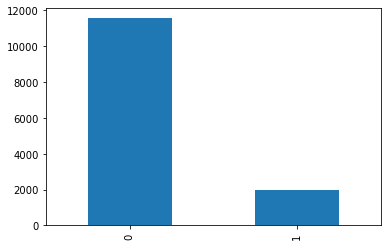

In [64]:
ax = data2['response'].value_counts().plot(kind='bar')

Option 2: fancy plot

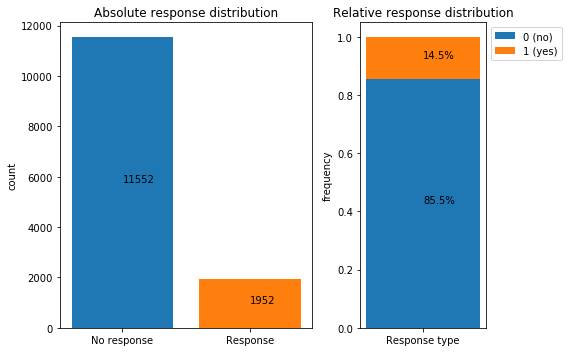

In [65]:
# plot response
keys, counts = np.unique(data2.response, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No response', 'Response'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Absolute response distribution') 
ax0 = plt.ylabel('count')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Response type'], [counts_norm[0]], label='0 (no)')
ax1 = plt.bar(['Response type'], [counts_norm[1]], bottom=counts_norm[0], label='1 (yes)')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative response distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Response type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Response type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

We observe that the "no response" cases account for 85.5% of all observations. As in Tutorial 1, we are faced with a highly imbalanced data set. This week, however, we will introduce some tools to counter the class imbalance!

#### Response type by gender

Option 1: simple Pandas plot

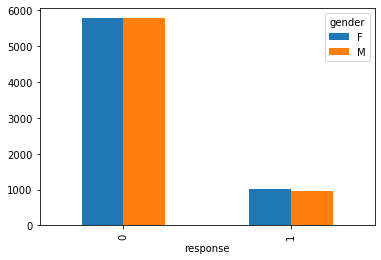

In [66]:
ax = data2.groupby(['response', 'gender'])['gender'].count().unstack().plot.bar()

Option 2: fancy plot

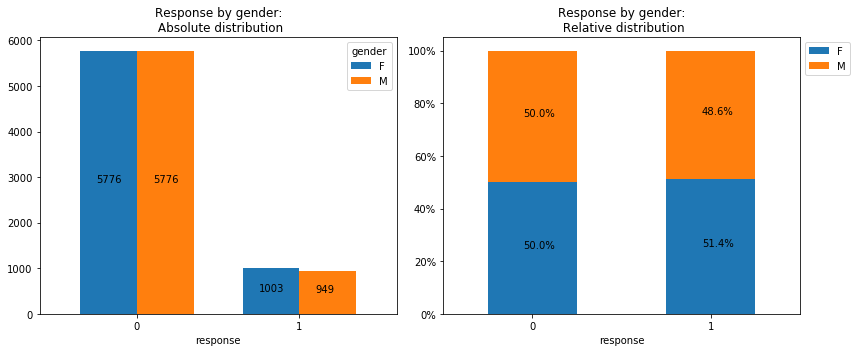

In [67]:
#Response type by gender
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data2.groupby(['response', 'gender'])['gender'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by gender:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data2.groupby(['response','gender'])['gender'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Response by gender:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

We observe an equal distribution in the response behavior amongst women and men.

#### Relative income distribution

Next, we plot the relative income distribution. Below an income level of 55000, we observe a relatively equal distribution of "yes" to "no" responses. **However, *all* customers with an income of 55000 or higher seem to respond to our marketing campaign!** The campaign appears to be highy affective amongst this group.

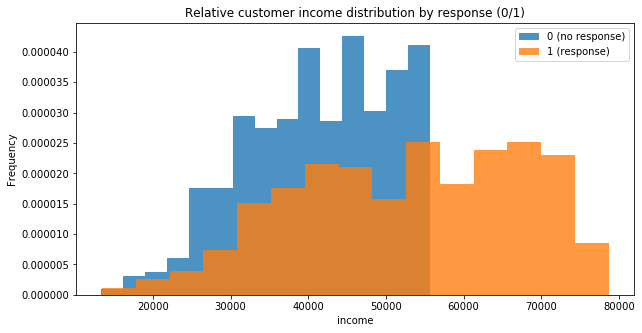

In [68]:
ax = data2['income'].loc[data2['response'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no response)', figsize = (10,5))
ax = data2['income'].loc[data2['response'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (response)', figsize = (10,5))
ax.set_xlabel('income')
ax.set_title('Relative customer income distribution by response (0/1)')
ax.legend();

#### Response type by relationship status

Next, we plot the absolute and normalized responses by relationship status. We observe an equal response distribution amongst married customers ("M"), singles ("S"), and unknow ("U" aka. "it's complicated")

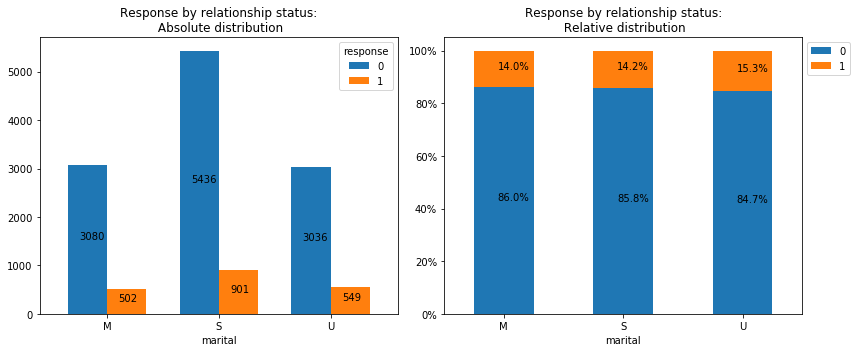

In [69]:
#Response type by gender
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data2.groupby(['marital', 'response'])['response'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by relationship status:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data2.groupby(['marital','response'])['response'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Response by relationship status:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

#### Responses by relative RFM score

Last, we plot the reponses by the customer's relative [RFM score](https://en.wikipedia.org/wiki/RFM_(customer_value)). (From Wiki:) RFM is a method used for analyzing customer value and describes three dimensions:

- Recency – How recently did the customer purchase?
- Frequency – How often do they purchase?
- Monetary Value – How much do they spend?

Plotting the RFM score as a histogram reveals how customers with a low RFM score do not respond to the campaign. Customers with a high RFM score seem to always respond. 

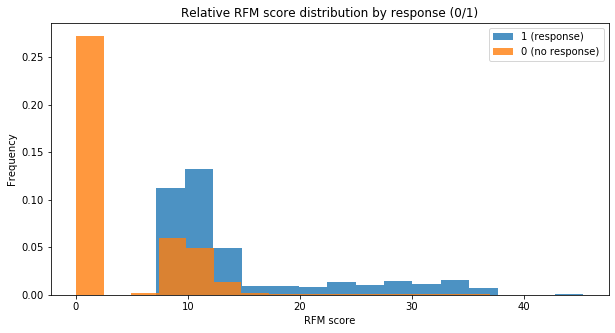

In [70]:
ax = data2['rfm_score'].loc[data2['response'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (response)', figsize = (10,5))
ax = data2['rfm_score'].loc[data2['response'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no response)', figsize = (10,5))
ax.set_xlabel('RFM score')
ax.set_title('Relative RFM score distribution by response (0/1)')
ax.legend();

## 4. Data pre-processing

#### Select features and label

We store the 4 explanatory variables (`gender`, `income`, `marital` and `rfm_score`) in a new feature data frame `X`. Moreover, we store the label (`response`) in a label vector `y`:

In [71]:
X, y = data2[['gender', 'income', 'marital', 'rfm_score']], data2['response'] #define feature matrix X and labels y
X.head()

,gender,income,marital,rfm_score
0,M,13362,S,0.00000
1,M,13453,S,0.00000
2,F,13453,U,7.60233
3,F,13453,U,10.14300
4,F,13453,M,0.00000


#### Encode categorical variables

The variables `gender` and `marital` are categorical and require label encoding so that the models can use them. We perform one-hot-encoding using Panda's "get_dummeies()" function.

In [72]:
X = pd.get_dummies(X, columns=["gender", "marital"], prefix=["gender", "marital"]) #we add a prefix for easier identification
X.head()

,income,rfm_score,gender_F,gender_M,marital_M,marital_S,marital_U
0,13362,0.00000,0,1,0,1,0
1,13453,0.00000,0,1,0,1,0
2,13453,7.60233,1,0,0,0,1
3,13453,10.14300,1,0,0,0,1
4,13453,0.00000,1,0,1,0,0


## 5. Data split

We split the data 70:30 into a training (`data_train`) and a testing (`data_test`) partition. 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) #split data 70:30

We visualize the split to ensure that the distribution of "yes" to "no" responses matches the distribution in the full dataset.

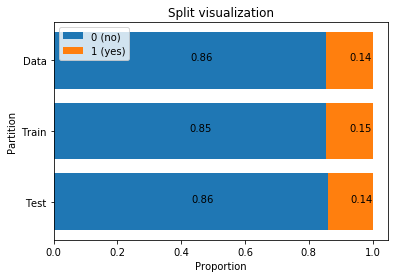

In [74]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## 6. Data balancing

A widely adopted technique for dealing with highly unbalanced datasets is called **resampling**. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

<img src="Images/resampling.png" width="800">

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

There are many techniques for resampling data. In this tutorial, we will use **SMOTE** (Synthetic Minority Oversampling TEchnique). It consists of synthesizing elements for the minority class, based on those that already exist. It works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

<img src="Images/smote.png" width="800">

We'll use `ratio='minority'` to resample the minority class (1 "yes").

### Data rebalancing with SMOTE

<font color='red'>**We only rebalance the training data!**</font> The true (real-life) distribution of "no" to "yes" responses is imbalanced. The testing data has to capture the true distribution, thus it would be wrong to rebalance it. 

In [75]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train) #ONLY APPLIED TO TRAINING!!!

Because the dataset has many dimensions (features) and our graphs will be 2D, we will only choose the first two features (`income` and `rfm_score`) for the plots. Below we specify a generic 2D plotting function that we can call later.

In [76]:
def plot_2d_space(X, y, label='Classes', title='x', xlabel='x', ylabel='y'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=2
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')

Then we plot the counts of "no" and "yes" responses in the original data and after applying SMOTE rebalancing. 

Original label Counter({0: 8063, 1: 1389})
SMOTE label Counter({0: 8063, 1: 8063})


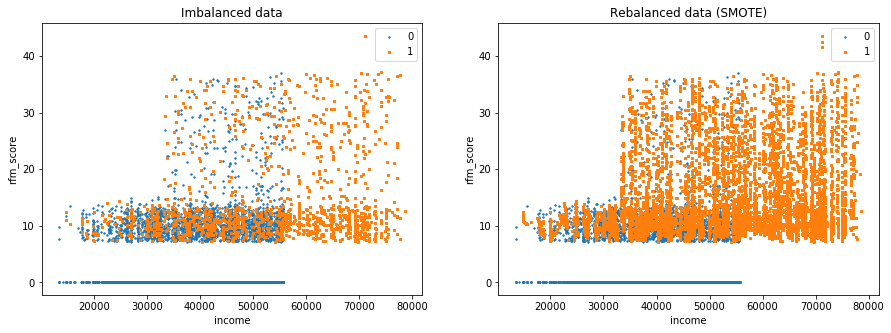

In [77]:
print('Original label %s' % Counter(y_train))
print('SMOTE label %s' % Counter(y_sm))

fig = plt.figure(figsize=(15, 5)) #specify figure size

ax0 = plt.subplot(121)
ax0 = plot_2d_space(np.array(X_train), y_train, title='Imbalanced data', xlabel='income', ylabel='rfm_score')

ax1 = plt.subplot(122)
ax1 = plot_2d_space(np.array(X_sm), y_sm, title='Rebalanced data (SMOTE)', xlabel='income', ylabel='rfm_score')

The number of `response` = 1 observations has significantly increased. We plot the data set distribution again to further visualize the effect of SMOTE rebalancing:

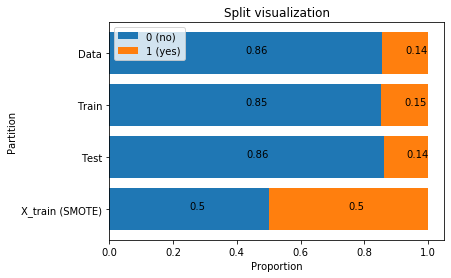

In [78]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['X_train (SMOTE)', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

<font color='red'>**Note how the testing partition remains imbalanced!**</font> 

## 7. Model building

### 7.1 Logistic Regression

#### 7.1.1 Imbalanced data
To highlight the positive effect of rebalancing, we first train a model on the original, unbalanced data set. Note that this is purely for illustrative purposes and would not be done in an actual assignment.

In [79]:
lr_imb = LogisticRegression(solver='lbfgs').fit(X_train, y_train) #define Logistic Regression classifier

In [80]:
y_pred_lr_imb = lr_imb.predict(X_test)
y_predProba_lr_imb = lr_imb.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_imb)*100).round(2))

Accuracy is:  85.17


#### 7.1.2 Balanced data (SMOTE)

Next, we train the actual Logistic Regression model (that we expect to perform somewhat well) using the rebalanced data.

In [81]:
lr_bal = LogisticRegression(solver='lbfgs').fit(X_sm, y_sm) #define Logistic Regression classifier

In [82]:
y_pred_lr_bal = lr_bal.predict(X_test)
y_predProba_lr_bal = lr_bal.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

Accuracy is:  69.62


Note how the rebalanced data leads to a *decreased* accuracy.

### 7.2 SVM

In order to compare models, we also train another classifier using SVM.

In [83]:
svm_bal = SVC(probability=True).fit(X_sm, y_sm)

In [90]:
y_pred_svm_bal = svm_bal.predict(X_test)
y_predProba_svm_bal = svm_bal.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_bal)*100).round(2))

Accuracy is:  87.93


## Model evaluation

In this tutorial, we will use the following evaluation methods:
- Confusion matrix
- AUC (Area Under the Curve) and ROC curve
- Gains chart
- Lift chart

### Confusion matrix

(Reminder that the code below is entirely taken from sklearn).

In [91]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3322  167]
 [ 434  129]]
Normalized confusion matrix
[[0.95 0.05]
 [0.77 0.23]]
Confusion matrix, without normalization
[[2343 1146]
 [  85  478]]
Normalized confusion matrix
[[0.67 0.33]
 [0.15 0.85]]
Confusion matrix, without normalization
[[3274  215]
 [ 274  289]]
Normalized confusion matrix
[[0.94 0.06]
 [0.49 0.51]]


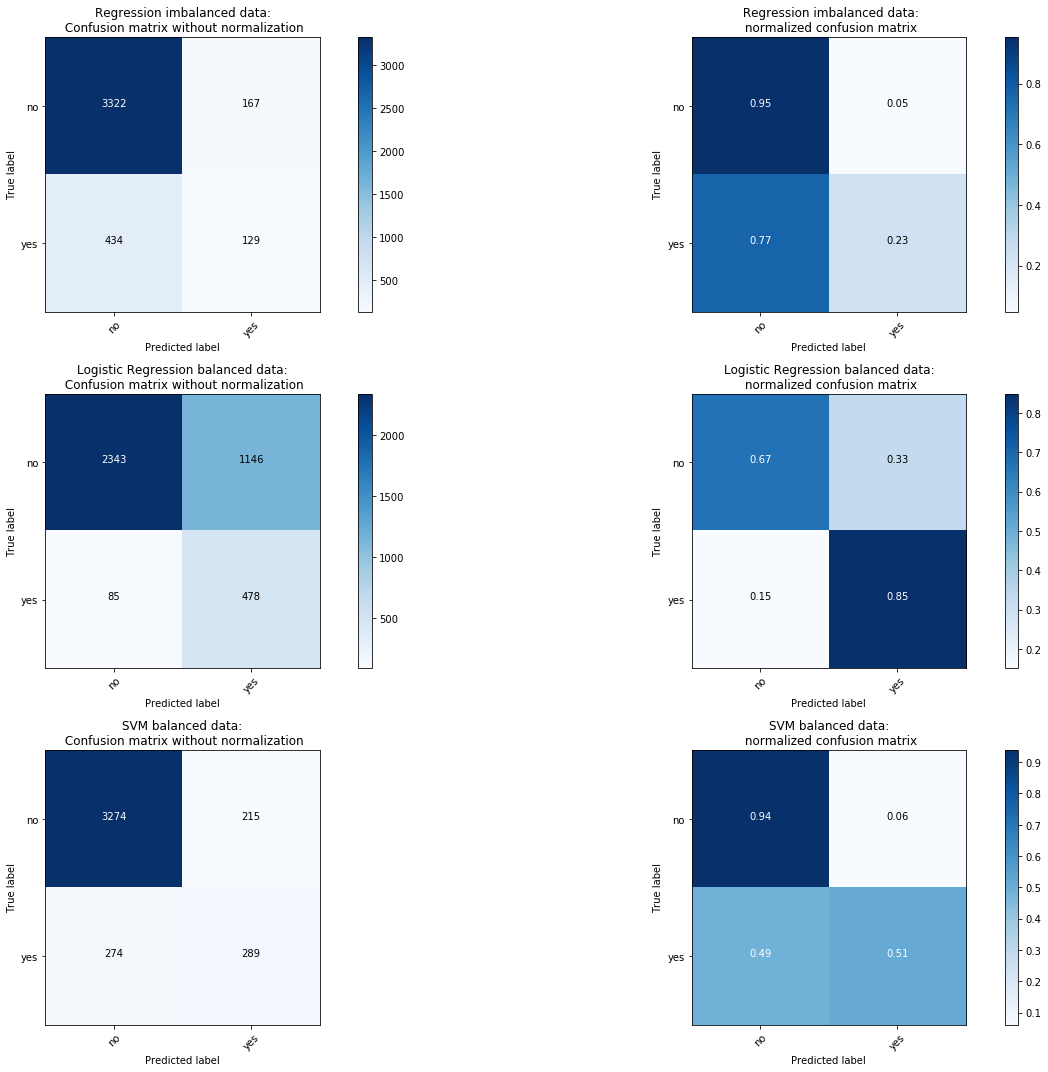

In [92]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_lr_imb = confusion_matrix(y_test, y_pred_lr_imb)
cnf_matrix_lr_bal = confusion_matrix(y_test, y_pred_lr_bal)
cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot Logistic Regression (imbalanced) confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names,
                      title='Regression imbalanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (imbalanced) normalized confusion matrix
plt.subplot(322) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names, normalize=True,
                      title=' Regression imbalanced data:\n normalized confusion matrix')


#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names,
                      title='Logistic Regression balanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) normalized onfusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names, normalize=True,
                      title='Logistic Regression balanced data:\n normalized confusion matrix')


#Plot SVM balanced confusion matrix
plt.subplot(325) 
plot_confusion_matrix(cnf_matrix_svm, classes=class_names,
                      title='SVM balanced data:\n Confusion matrix without normalization')

#Plot SVM balanced normalized confusion matrix
plt.subplot(326) 
plot_confusion_matrix(cnf_matrix_svm, classes=class_names, normalize=True,
                      title='SVM balanced data:\n normalized confusion matrix')

plt.show()

Observations:
1. The confusion matrix reveals how the unbalanced Logistic Regression classifier is essentially always predicting the majority class "0, no". Due to the highly imbalanced class distribution, this strategy results in a high testing accuracy of 85%. In simply terms: if the data has >85% "no" observations then always predicting "no" will result in about 85% correct "predictions". However, such a classifier has clearly not learned anything and is utterly useless in practice.
2. In contrast, the balanced Logistic Regression classifier performs much better: while it "only" identifies 67% of the "no" cases correctly, it is able to get 85% of the "yes" cases right. 
3. Lastly, the balanced SVM classifier gets 94% "no" and 51% "yes" cases right.

Which model woudl you pick?

### AUC and ROC

The area under the curve (often referred to as simply the AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. 

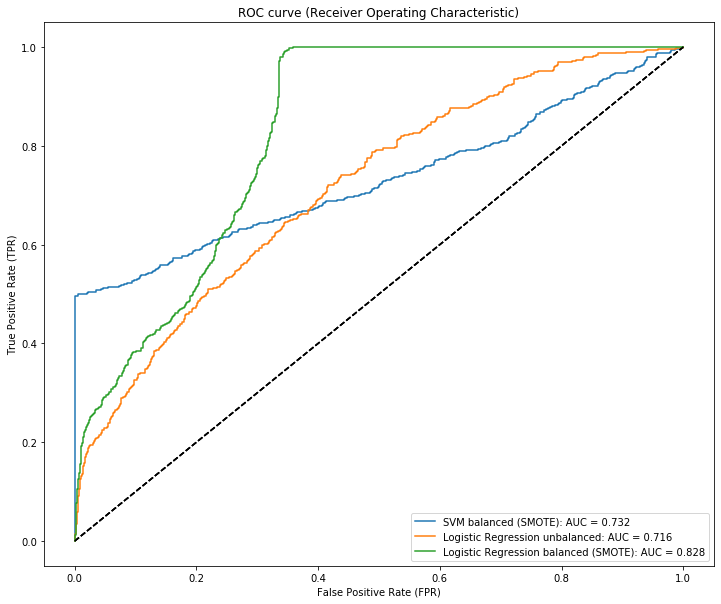

In [93]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test], [y_predProba_svm_bal[:,1], y_predProba_lr_imb[:,1], y_predProba_lr_bal[:,1]], ['SVM balanced (SMOTE)', 'Logistic Regression unbalanced','Logistic Regression balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

### Cumulative Response Curve, aka. Gains chart

From DSB1 slides:
- A Gain chart plots the **gain** (percentage of positives correctly classified by model; tp rate; hit rate) as a function of the **percentage of the population** that is targeted (decreasing by score)
- The diagonal x=y represents a random classifier; any classifier that is above the diagonal is providing some advantage

A wide gap between a random classifier (baseline) and a model indicates a high performance advantage in using said model. 

From Datacamp:
The cumulative gains graph can be used to estimate how many customers one should address to make a certain profit. Indeed, the cumulative gains graph shows which percentage of all targets is reached when addressing a certain percentage of the population.

So what does this mean?

In order to get a 80% True Positive hit rate, we would need to target ca. 30% of the population with the SVM model, and ca. 40% with the Logistic Regression model. The SVM model shows some "sweet spot" around 75% gain after which the curve becomes flatter.

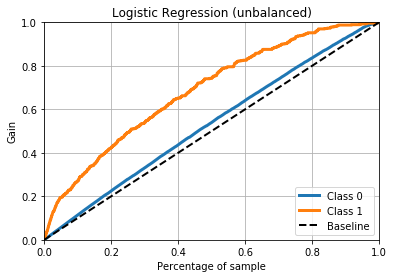

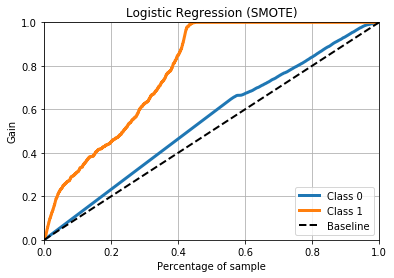

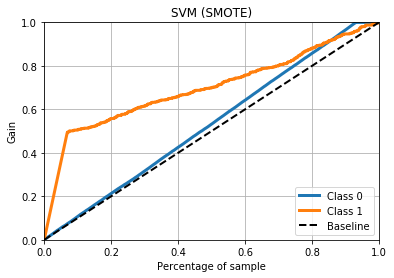

In [94]:
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr_imb, title='Logistic Regression (unbalanced)')
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr_bal, title='Logistic Regression (SMOTE)')
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_svm_bal, title='SVM (SMOTE)');

Which model should we choose? 
- Rebalancing clearly improves the models' performance
- still unclear wheather to choose SVM or Logistic Regression

**--> It depends on the missclassification costs whether to choose SVM or Logistic Regression.**

## Classifier evaluation with Expected Value Framework -> EXCEL

## Conclusion

In this tutorial we learned:
- how to important data and slice a subset for further analysis
- how to visualize data
- how to to rebalance imbalanced data using SMOTE oversampling
- how to train SVM and Logistic Regression models
- how to evaluate model performance using confusion matrices, AUC and ROC curves, Gain charts, and charts.
- how to compare models using the Expected Value Framework